In [1]:
## Current script with hopes of being the master script, applicable for all processes/tools/steps/wavelengths
## /etc
import pandas as pd
import glob
import os
import numpy as np
import dask.dataframe as dd
from datetime import datetime,timedelta
import time
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy import interpolate, stats
import seaborn as sns
from tqdm import tqdm                       # For progress bar, yay!0


In [3]:
# Retrieving Metro Data from .txt files
mfile = []
metro = {}
metro_cols = ['waferscribe','ext_mv']
print('Reading Metro Data')
for filename in glob.glob("metro/22*"): # GH v 22 for STII
    metro[filename[6:-4]] = pd.read_csv(filename,usecols=metro_cols)[metro_cols] 
        # Using filenames w/out path and file type as dictionary keys
    mfile.append(filename[6:-4])  
        # Create index of filename strings
    print(f'\t{filename} Data Finished')
    met = pd.concat(metro.values(),ignore_index=True)

# Trim down 'met' to relevant ext_mv values
paramVal = met['ext_mv']
paramBool = met[paramVal%1==0]
dropParam = paramBool.index
met.drop(dropParam, inplace=True)
MetroWafers = met.waferscribe

Reading Metro Data
	metro\22STIINT.txt Data Finished


In [4]:
# Retrieving OES Data from the .csv files, takes MUCH longer, retrieving specfic columns helps
ofile = []
oes = {}
data = {}
oes_cols = ['WAFER_SCRIBE','RunStartTime', 'TimeStamp','StepID', 'OES_CO483', 'OES_C516', 'OES_CN387'] # For STI INTEGRATED 
#oes_cols = ['LOT_ID','WAFER_SCRIBE','RunStartTime', 'TimeStamp','StepID', 'OES_BCl272', 'OES_C516', 'OES_CN387', 'OES_CO483', 'OES_F703', 'OES_H656', 'OES_O777', 'OES_OH309','OES_Si251','OES_Si288'] # For STI INTEGRATED
#oes_cols = ['WAFER_SCRIBE','RunStartTime', 'TimeStamp','StepID', 'OESIB1', 'OESIB2', 'OESIB3', 'OESIB4', 'OESIB5', 'OESIB6', 'OESIB7', 'OESIB8'] # For GH CONTACT 
print('Reading OES Data')
for filename in glob.glob("oes/5030-22 STI INTEGRATED DRY ETCH_*.csv"): #5030-22 STI INTEGRATED DRY ETCH_1 #3500-GH CONTACT OXIDE DRY ETCH_10.csv
    oes[filename[4:-4]] = pd.read_csv(filename, usecols=oes_cols,parse_dates=['RunStartTime', 'TimeStamp'],infer_datetime_format=True)[oes_cols]
    ofile.append(filename[4:-4]) # Create index of filename strings
    data = pd.concat(oes.values(),ignore_index=True) # Struggles with STI INTEGRATED data # pd.concat(oes.values(),ignore_index=True)
    print(f'\t{filename} Data Finished')

# Trim down 'data' to only metro-matching wafers by removing them
UniqueWafers = data.WAFER_SCRIBE.unique()
nonWafers = np.isin(UniqueWafers,list(MetroWafers),invert=True)
i = np.where(nonWafers)[0]
WaferScribe = []
WaferScribe = (UniqueWafers[i])

Reading OES Data
	oes\5030-22 STI INTEGRATED DRY ETCH_2.csv Data Finished
	oes\5030-22 STI INTEGRATED DRY ETCH_3.csv Data Finished
	oes\5030-22 STI INTEGRATED DRY ETCH_4.csv Data Finished


In [5]:
print('Trimming Down Data to Only Metro-Matching Wafers')
indexNames = []
for x in tqdm(WaferScribe):
    WaferScribeData = data['WAFER_SCRIBE']
    dataindex = data[WaferScribeData == x]
    indexNames = dataindex.index
    data.drop(indexNames , inplace=True)
print('\tDone!') 
UniqueWafers = data.WAFER_SCRIBE.unique()

  0%|                                                                                          | 0/575 [00:00<?, ?it/s]

Trimming Down Data to Only Metro-Matching Wafers


100%|████████████████████████████████████████████████████████████████████████████████| 575/575 [02:34<00:00,  3.73it/s]

	Done!


In [7]:
# Turning Data into Wafer for easy keys and converting dates into 
t_sec = {}
Wafer = {}
DataFrameDict = {elem : pd.DataFrame for elem in UniqueWafers}
print('Creating Wafer Data Set & Processing Dates into Time in Seconds')
for i,key in enumerate(tqdm(DataFrameDict.keys())):
    Wafer[i] = pd.DataFrame.from_dict(data[:][data.WAFER_SCRIBE == key]) # Create DataFrame for specific wafers
    delt = Wafer[i]['TimeStamp']-Wafer[i]['RunStartTime'] # Find timedelta for a wafer
    t_sec[i] = delt.dt.total_seconds() # Put timedelta into seconds
print('\tDone!')
OES_col = [col for col in Wafer[i].columns if 'OES' in col] #Create list of all intensity columns w/rt element
step = 6
wafer_param_time = met[['waferscribe','ext_mv']]
etch_time = []
peakTime = []
waferScribe = []

 12%|█████████▉                                                                         | 6/50 [00:00<00:00, 57.06it/s]

Creating Wafer Data Set & Processing Dates into Time in Seconds


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 68.82it/s]

	Done!


[ 272542.07419697   83183.22532196 -130556.68222979]
<class 'numpy.ndarray'>
[array([ True,  True, False])]
<class 'list'>
[2 9]
<class 'numpy.ndarray'>
	Wafer Scribe: PQZRJ107MXG5, 0/50
x_int[peaks]:	 [122.32672727]
y_int[peaks]:	 [228410.27394069]
x_int[-1]-x_int[peaks]:	 [16.99727273]
[1.699727272727273, 1.9092929292929313, 1.5192727272727211, 1.718090909090904, 1.7091818181818184, 1.7081818181818136, 1.6990909090909128, 1.910404040404046, 0.5731212121212081, 1.7090000000000032, 1.708818181818188, 0.5727272727272776, 0.5700303030303076, 0.3796969696969654, 1.718545454545449, 0.37789898989899484, 1.699727272727273]
[ 208903.61151994   97191.36983137 -122526.5691742 ]
<class 'numpy.ndarray'>
[array([ True,  True, False])]
<class 'list'>
[ 3 10]
<class 'numpy.ndarray'>
	Wafer Scribe: PQZRJ104MXB2, 1/50
x_int[peaks]:	 [121.11729293]
y_int[peaks]:	 [224946.4423275]
x_int[-1]-x_int[peaks]:	 [16.99270707]
[1.699727272727273, 1.9092929292929313, 1.5192727272727211, 1.718090909090904, 1.7091

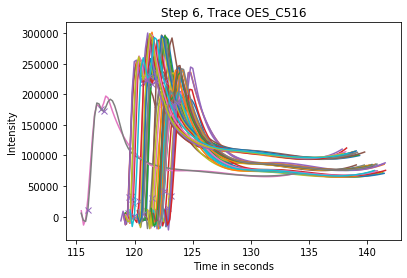

In [10]:
# Only temporarily kept in here
for x in range (len(UniqueWafers)):
    #fig = plt.figure()
    Tsteps = t_sec[x].loc[Wafer[x]['StepID']==step]
    #print(Tsteps)
    x_int = np.linspace(Tsteps.iloc[0], Tsteps.iloc[-1], 100)
    #plt.axvspan(Tsteps.iloc[0], Tsteps.iloc[-1], alpha=0.25) #, ymin=0, ymax=1, **kwargs)
    plt.title("Step 6, Trace OES_C516") #f"Wafer Scribe: {UniqueWafers[x]}, {x}/{len(UniqueWafers)}")
    for y in range(1,2): # (len(OES_col)): #
        Intensity = Wafer[x][OES_col[y]].loc[Wafer[x]['StepID']==step]
        #plt.plot(Tsteps,Intensity, label=f"{OES_col[y]}") #,color="tab:orange")                    # OG Data
        tck = interpolate.splrep(Tsteps,Intensity, k = 3, s = 1e10)
        y_int = interpolate.splev(x_int, tck, der = 0)
        plt.plot(x_int,y_int, label=f"{UniqueWafers[x]}") #Smooth {OES_col[y]}")#,color="tab:blue")                      # Smoothed Data
        first = interpolate.splev(x_int, tck, der = 1)
        #plt.plot(x_int,first, label=f"1st {OES_col[y]}",linestyle = '--',color="tab:red")          # First Derivative Plot
        second = interpolate.splev(x_int, tck, der = 2)
        peaks, _ = find_peaks(second) #, height=4e5) #, distance=7)
        print(first[peaks])
        print(type(first[peaks]))
        print([first[peaks]>0])
        print(type([first[peaks]>0]))
        print(peaks[first[peaks]>0])
        print(type(peaks[first[peaks]>0]))
        peaks = peaks[first[peaks]>0]
        peaks = peaks[y_int[peaks]>0]
        #peaks = peaks[y_int[peaks]<2.6e5]
        #peaks = peaks[x_int[-1]-x_int[peaks]>17.05]    #                       Checking out peak alignment
        #peaks = peaks[x_int[-1]-x_int[peaks]>17.15]
        #peaks = peaks[x_int[-1]-x_int[peaks]<17.22]
        #peaks = peaks[x_int[-1]-x_int[peaks]<17.5]
        #peaks = peaks[x_int[peaks]-x_int[0]>1.715] # 1.650, 1.705, 1.715       Checking out peak alignment
        #peaks = peaks[x_int[peaks]-x_int[0]<1.8]  # 1.705, 1.715, 1.800
        #plt.plot(x_int,second, label=f"2nd {OES_col[y]}",linestyle = ':',color="tab:green")        # Second Derivative Plot
        #plt.plot(x_int[peaks], second[peaks], "x",color="tab:purple", label = "Peaks")             # First Derivative Peaks
        #plt.plot(x_int[peaks], first[peaks], "x",color="tab:purple", label = "Peaks")              # Second Derivative Peaks
        plt.plot(x_int[peaks], y_int[peaks], "x",color="tab:purple", label = "Peaks")              # Smoothed Peaks

        print(f"\tWafer Scribe: {UniqueWafers[x]}, {x}/{len(UniqueWafers)}")
        print("x_int[peaks]:\t",x_int[peaks])
        print("y_int[peaks]:\t",y_int[peaks])
        print("x_int[-1]-x_int[peaks]:\t",x_int[-1]-x_int[peaks])

        #print(x,len(peaks))
        #plt.ylim(0,4e5)
        #etch_time.update({'waferscribe':UniqueWafers[x],'peaks':x_int[peaks[0]]})
        #waferScribe.append(UniqueWafers[x])
        try:
            peakTime.append(x_int[peaks[0]]-x_int[0]) # x_int[peaks[0]]) # try/except -- taking in the first value within x-int[peaks]: x_int[-1]-x_int[peaks[0]]
            waferScribe.append(UniqueWafers[x])
        except IndexError:
            pass
        print(peakTime)
        #print(type(x_int[peaks[0]]-x_int[0]))
        
    plt.ylabel("Intensity")
    plt.xlabel("Time in seconds")
    #plt.legend()
    #plt.show()
#plt.show()

     waferscribe     peaks      ext_mv
0   PQZRJ107MXG5  1.699727  335.474500
1   PQZRJ104MXB2  1.909293  335.393417
2   PQZRJ097MXD6  1.519273  337.756250
3   PQZRJ094MXF6  1.718091  338.352167
4   DC1SQ073SEB0  1.709182  337.591833
5   DC1SQ076SEG3  1.708182  338.514500
6   DJ2TU004SEE0  1.699091  336.540417
7   DJ2TU007SEC0  1.910404  336.436750
8   DJ2AQ293SEC1  0.573121  337.891083
9   DJ2AQ290SEE1  1.709000  338.675000
10  DJ1SR329SED4  1.708818  333.600000
11  DJ1SR326SEF4  0.572727  333.628417
12  DJ1SR304SEC6  0.570030  338.427250
13  DJ1SR301SEE6  0.379697  338.507333
14  DJ1SR338SED6  1.718545  337.615667
15  DJ1SR335SEF6  0.377899  338.813750
R-squared: 0.045593437091219935


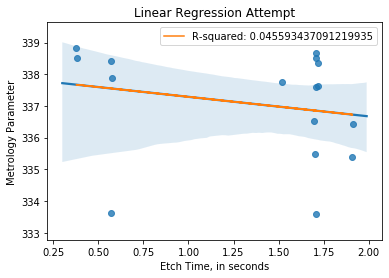

In [9]:
etch_time = pd.DataFrame({'waferscribe':waferScribe,'peaks':peakTime})

#etch_time.drop(etch_time.loc[etch_time['peaks'] < 1,'peaks'].index, inplace=True)      # Is this doing anything? I don't think so...
#etch_time.drop(etch_time.loc[etch_time['peaks'] > 30,'peaks'].index, inplace=True)

#print('Etch',(etch_time))
#print('Param',(wafer_param_time))
result = pd.merge(etch_time, wafer_param_time, on = ['waferscribe'])
print(result)
slope, intercept, r_value, p_value, std_err = stats.linregress(x=result.peaks, y=result.ext_mv)
print(f"R-squared: {r_value**2}")
fig = plt.figure()
sns.regplot(x=result.peaks, y=result.ext_mv)
#plt.scatter(result.peaks, result.ext_mv)
plt.plot(result.peaks, result.peaks*slope+intercept, label = f"R-squared: {r_value**2}")
plt.title("Linear Regression Attempt")
plt.ylabel("Metrology Parameter")
plt.xlabel("Etch Time, in seconds")
plt.legend()
plt.show()
